In [1]:
import sys
sys.path.append("..")
sys.path.append(".")
import os
import json

from layers import *
from blocks import *
from utils import *

from stable import *

import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logdir = "log_stable"
if not os.path.exists(logdir):
    os.mkdir(logdir)

# Regnet parameters
widths = [56, 28, 14, 7]  # size of featuremap, after downsampling

def regnet_parameters(num):
    channels = None
    group = None

    if num == "002":
        channels = [24, 56, 152, 368]
        group = 8
    elif num == "004":
        channels = [32, 64, 160, 384]
        group = 16
    elif num == "006":
        channels = [48, 96, 240, 528]
        group = 24
    elif num == "008":
        channels = [64, 128, 288, 672]
        group = 16
    else:
        raise NotImplementedError

    return channels, group

def get_factors(num):
    factors = []
    if num == 7:
        factors = [1, 7]
    elif num == 14:
        factors = [1, 2, 7]
    elif num == 28:
        factors = [1, 2, 4, 7, 14]
    elif num == 56:
        factors = [1, 2, 4, 7, 8, 14, 28]
    return factors


In [3]:
# test stability on one regnet's parameters
channels, group = regnet_parameters("006")

for i, width in enumerate(widths):
    channel = channels[i]
    bs = TVMDynamicBlockEvaluator(channel, width, group, f"log_stable/c{channel}_w{width}_g{group}")

    # dense part
    # print(bs())
    bs.setup()
    for name, layer in bs.layers.items():
        res = test_stability(layer, 300, 5)
        mean = np(res).mean()
        std = np(res).std()
        print(f"layer={name} mean={mean} std={std}")


    # sparse part
    # factors = get_factors(width)
    # for g in factors:
    #     for s in [0.25, 0.5, 0.75]:
    #         s = int(s * ((width// g) ** 2))
    #         print(bs("sparse", s, g, True, True, True))



TypeError: __call__() missing 2 required positional arguments: 'sparselen' and 'granularity'

/usr/local/lib/python3.8/dist-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/usr/local/lib/python3.8/dist-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/usr/local/lib/python3.8/dist-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/usr/local/lib/python3.8/dist-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is depr

([0.00044418884,
  0.0005234641100000001,
  0.0006026666299999999,
  0.00030997701,
  0.00030182296,
  0.00020503444],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

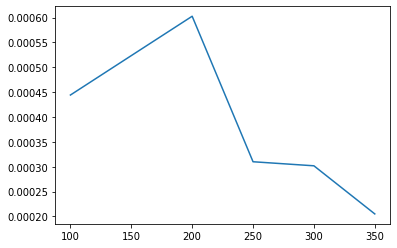

In [6]:
# checking correctness
s = Conv3x3GatheredScheduler(512, 4, 128, 2, logdir+"/conv2.json")
test_perf_curve(s, list(range(100, 400, 50)), plot=True)